# 文本分类实例-英文评论情感预测（Text Classification Example - English Comment Emotion Prediction）

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 数据读取和观察

In [3]:
# 使用pandas打开csv文件
data = pd.read_csv('./dataset/Tweets.csv')
# 查看数据
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# 分离评价内容和对应的情感标签
data = data[['airline_sentiment', 'text']]
# 查看数据信息
data.info()
# 查看是否有重复值
print("Rebeated rows: ", data.duplicated().sum())
# 除去数据中的重复值
data.drop_duplicates(inplace=True)
# 查看重复值是否去除
print("Rebeated rows after drop: ", data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB
Rebeated rows:  188
Rebeated rows after drop:  0


In [5]:
# 查看情感标签
print(data.airline_sentiment.unique())
# 查看情感标签的分布是否均衡
data.airline_sentiment.value_counts()

['neutral' 'positive' 'negative']


negative    9087
neutral     3067
positive    2298
Name: airline_sentiment, dtype: int64

In [6]:
# 查看当前处理后的数据
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [7]:
# 标签的处理
# 将情感标签转换为数字
data['review'] = pd.factorize(data.airline_sentiment)[0]
# 删除情感标签列
del data['airline_sentiment']
# 查看当前处理后的数据
data.head()

,text,review
0,@VirginAmerica What @dhepburn said.,0
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,2
4,@VirginAmerica and it's a really big bad thing...,2


In [8]:
# 文本的处理
import re
# 定义一个正则表达式，用于匹配文本中的单词和标点符号
token = re.compile('[A-Za-z]+|[!?,.()]')
# 文本处理函数
def reg_text(text):
    new_text = token.findall(text)
    new_text = [word.lower() for word in new_text]
    return new_text
# 处理文本
data['text'] = data.text.apply(reg_text)
# 查看处理后的文本
data.head()

,text,review
0,"[virginamerica, what, dhepburn, said, .]",0
1,"[virginamerica, plus, you, ve, added, commerci...",1
2,"[virginamerica, i, didn, t, today, ., ., ., mu...",0
3,"[virginamerica, it, s, really, aggressive, to,...",2
4,"[virginamerica, and, it, s, a, really, big, ba...",2


## 创建词表（vocab）

In [9]:
# 初始化空集合
word_set = set()
# 遍历数据集中的所有文本，将每个单词添加到集合中
for text in data.text:
    for word in text:
        word_set.add(word)
# 打印集合的大小，即词汇表的大小
max_word = len(word_set) + 1
print(max_word)

13668


In [10]:
# 将集合转换为列表
word_list = list(word_set)
# 查找单词在列表中的索引
word_list.index('spending')

557

In [11]:
# 从列表构建字典
word_index =  dict((word, word_list.index(word) + 1) for word in word_list)
word_index

{'transatlantic': 1,
 'whose': 2,
 'ljzdthd': 3,
 'gb': 4,
 'memory': 5,
 'onholdfordays': 6,
 'ellen': 7,
 'brendanpshannon': 8,
 'ttno': 9,
 'damper': 10,
 'yoga': 11,
 'st': 12,
 'parachuteguy': 13,
 'mystery': 14,
 'upocmmulun': 15,
 'superhero': 16,
 'impediment': 17,
 'ordered': 18,
 'hello': 19,
 'fri': 20,
 'boh': 21,
 'agfd': 22,
 'faa': 23,
 'bape': 24,
 'taylor': 25,
 'oq': 26,
 'jimtrotter': 27,
 'suite': 28,
 'bloody': 29,
 'toiletries': 30,
 'relief': 31,
 'brandssayingbae': 32,
 'full': 33,
 'willl': 34,
 'pk': 35,
 'nada': 36,
 'jockeying': 37,
 'clouds': 38,
 'irixaifjjx': 39,
 'deplorable': 40,
 'nghmie': 41,
 'org': 42,
 'okcprofessionals': 43,
 'fool': 44,
 'fuel': 45,
 'xs': 46,
 'sundayfunday': 47,
 'siczx': 48,
 'robert': 49,
 'guc': 50,
 'analytics': 51,
 'taxies': 52,
 'chasefoster': 53,
 'hurts': 54,
 'colors': 55,
 'messed': 56,
 'skillful': 57,
 'continuing': 58,
 'take': 59,
 'appreciation': 60,
 'easy': 61,
 'resort': 62,
 'beautiful': 63,
 'rdtimethishash

## 文本数据预处理

In [12]:
# 查看数据文本
data.text

0                 [virginamerica, what, dhepburn, said, .]
1        [virginamerica, plus, you, ve, added, commerci...
2        [virginamerica, i, didn, t, today, ., ., ., mu...
3        [virginamerica, it, s, really, aggressive, to,...
4        [virginamerica, and, it, s, a, really, big, ba...
                               ...                        
14635    [americanair, thank, you, we, got, on, a, diff...
14636    [americanair, leaving, over, minutes, late, fl...
14637    [americanair, please, bring, american, airline...
14638    [americanair, you, have, my, money, ,, you, ch...
14639    [americanair, we, have, ppl, so, we, need, kno...
Name: text, Length: 14452, dtype: object

In [13]:
# 将单词使用词表进行编码
text = data.text.apply(lambda x: [word_index.get(word, 0) for word in x])
# 查看编码后的数据
text

0                         [8748, 12676, 7483, 12638, 6789]
1        [8748, 5555, 8987, 1267, 7916, 341, 3247, 1134...
2        [8748, 2548, 12380, 8927, 10317, 6789, 6789, 6...
3        [8748, 7460, 9564, 11686, 8472, 3247, 11185, 9...
4        [8748, 10491, 7460, 9564, 2052, 11686, 3139, 1...
                               ...                        
14635    [6500, 6125, 8987, 10895, 190, 1334, 2052, 127...
14636    [6500, 416, 10618, 8389, 8102, 1433, 6789, 131...
14637         [6500, 13656, 10665, 4479, 1901, 3247, 8756]
14638    [6500, 8987, 6981, 4718, 4427, 12520, 8987, 32...
14639    [6500, 10895, 6981, 765, 4648, 10895, 5902, 11...
Name: text, Length: 14452, dtype: object

In [14]:
# 获取最大评论长度
maxlen = max(len(x) for x in text)
print("Max length: ", maxlen)
# 将评论填充到最大长度
pad_text = [l + (maxlen-len(l))*[0] for l in text]
# 转化为numpy数组
pad_text = np.array(pad_text)
# 查看填充后的数据形状
print("pad_text.shape: ", pad_text.shape)
# 查看填充后的数据
pad_text[:5]

Max length:  40
pad_text.shape:  (14452, 40)


array([[ 8748, 12676,  7483, 12638,  6789,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [ 8748,  5555,  8987,  1267,  7916,   341,  3247, 11344,  6036,
         6789,  6789,  6789, 10398,  6789,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [ 8748,  2548, 12380,  8927, 10317,  6789,  6789,  6789,  7355,
         9994,  2548,  5902,  3247,    59,  5190, 11453, 10181,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [ 8748,  7460,  9564, 11686,  

## 标签数据预处理

In [15]:
# 获取标签数据
labels = data.review.values
# 查看标签数据形状
print("labels.shape: ", labels.shape)

labels.shape:  (14452,)


## 划分数据集

In [16]:
from sklearn.model_selection import train_test_split
# 划分数据集，使用默认的划分比例7.5：2.5
x_train, x_test, y_train, y_test = train_test_split(pad_text, labels)
x_train.shape, x_test.shape, y_train.shape

((10839, 40), (3613, 40), (10839,))

创建 dataset

In [ ]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, text_list, label_list):
        self.text_list = text_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        text = torch.LongTensor(self.text_list[index])
        label = self.label_list[index]
        return text, label

    def __len__(self):
        return len(self.text_list)

In [ ]:
train_ds = Mydataset(x_train, y_train)
test_ds = Mydataset(x_test, y_test)

In [ ]:
BTACH_SIZE = 16

In [ ]:
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BTACH_SIZE,
                                       shuffle=True
)

In [ ]:
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BTACH_SIZE
)

Embeding : 把文本映射为一个密集向量

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.em = nn.Embedding(max_word, 100)   # batch*maxlen*100
        self.fc1 = nn.Linear(maxlen*100, 1024)
        self.fc2 = nn.Linear(1024, 3)

    def forward(self, x):
        x = self.em(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = Net().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
        # x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [ ]:
epochs = 10

In [ ]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.051 accuracy: 0.67 test_loss：  0.046 test_accuracy: 0.686
epoch:  1 loss：  0.037 accuracy: 0.749 test_loss：  0.044 test_accuracy: 0.733
epoch:  2 loss：  0.025 accuracy: 0.835 test_loss：  0.045 test_accuracy: 0.742
epoch:  3 loss：  0.017 accuracy: 0.891 test_loss：  0.056 test_accuracy: 0.737
epoch:  4 loss：  0.011 accuracy: 0.931 test_loss：  0.062 test_accuracy: 0.735
epoch:  5 loss：  0.008 accuracy: 0.956 test_loss：  0.074 test_accuracy: 0.723
epoch:  6 loss：  0.006 accuracy: 0.965 test_loss：  0.09 test_accuracy: 0.729
epoch:  7 loss：  0.004 accuracy: 0.976 test_loss：  0.108 test_accuracy: 0.714
epoch:  8 loss：  0.004 accuracy: 0.982 test_loss：  0.104 test_accuracy: 0.714
epoch:  9 loss：  0.003 accuracy: 0.981 test_loss：  0.121 test_accuracy: 0.722


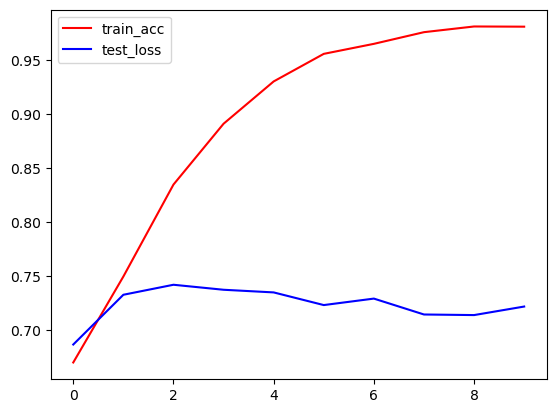

In [ ]:
plt.plot(range(epochs), train_acc, c='r', label='train_acc')
plt.plot(range(epochs), test_acc, c='b', label='test_loss')
plt.legend()

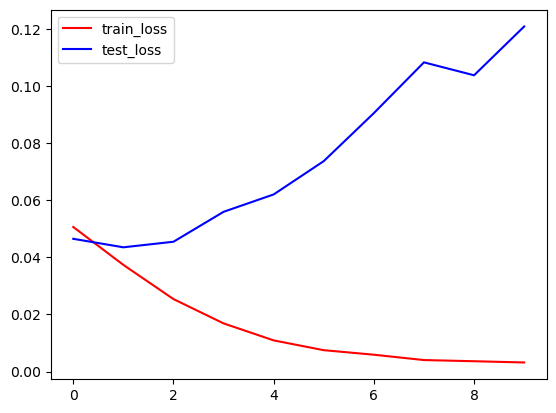

In [ ]:
plt.plot(range(epochs), train_loss, c='r', label='train_loss')
plt.plot(range(epochs), test_loss, c='b', label='test_loss')
plt.legend()

# 使用LSTM

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.em = nn.Embedding(max_word, 100)   # batch*maxlen*100
        self.lstm = nn.LSTM(100, 200, batch_first=True)
        self.fc1 = nn.Linear(200, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.em(x)
        x, _ = self.lstm(x)
        x = F.relu(self.fc1(x[:, -1, :]))
        x = self.fc2(x)
        return x

In [ ]:
model = Net().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 20

In [ ]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.058 accuracy: 0.627 test_loss：  0.057 test_accuracy: 0.625
epoch:  1 loss：  0.053 accuracy: 0.638 test_loss：  0.05 test_accuracy: 0.659
epoch:  2 loss：  0.045 accuracy: 0.689 test_loss：  0.044 test_accuracy: 0.681
epoch:  3 loss：  0.037 accuracy: 0.752 test_loss：  0.041 test_accuracy: 0.706
epoch:  4 loss：  0.03 accuracy: 0.813 test_loss：  0.039 test_accuracy: 0.763
epoch:  5 loss：  0.024 accuracy: 0.855 test_loss：  0.038 test_accuracy: 0.757
epoch:  6 loss：  0.019 accuracy: 0.892 test_loss：  0.043 test_accuracy: 0.755
epoch:  7 loss：  0.015 accuracy: 0.917 test_loss：  0.045 test_accuracy: 0.755
epoch:  8 loss：  0.012 accuracy: 0.939 test_loss：  0.048 test_accuracy: 0.752
epoch:  9 loss：  0.009 accuracy: 0.958 test_loss：  0.055 test_accuracy: 0.756
epoch:  10 loss：  0.007 accuracy: 0.969 test_loss：  0.062 test_accuracy: 0.747
epoch:  11 loss：  0.005 accuracy: 0.978 test_loss：  0.062 test_accuracy: 0.746
epoch:  12 loss：  0.004 accuracy: 0.983 test_loss：  0.075 test_a

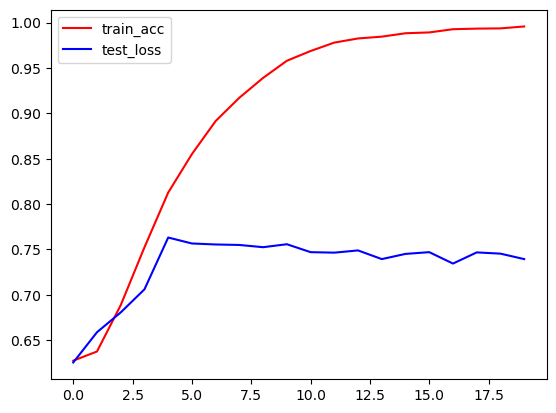

In [ ]:
plt.plot(range(epochs), train_acc, c='r', label='train_acc')
plt.plot(range(epochs), test_acc, c='b', label='test_loss')
plt.legend()

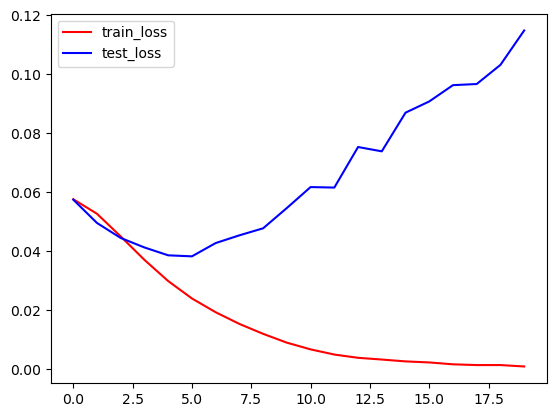

In [ ]:
plt.plot(range(epochs), train_loss, c='r', label='train_loss')
plt.plot(range(epochs), test_loss, c='b', label='test_loss')
plt.legend()